
-------------------------

# BCG Heart Rate detection using CWT and Autocorrelation


<b>General guidance for exercises</b>
- You can add more code and markup cells, as long as the flow of the notebook stays readable and logical. Some code is commented as "Don't touch" those code blocks should remain unmodified.
- If you encounter problems, Google first. If you can't find an answer to the problem, don't hesitate to send an email: Ismail Elnaggar (imelna@utu.fi).
- Start early! This could be an exercise that is hard to finish in one afternoon unless you are already familar with the topics covered. 

# Goals
* Use data from an open dataset which has time-synced ECG and BCG signals to calculate BCG heart rate and compare it to heart rate derived from ECG
* Use an autocorrelation based method on data to see performance of BCG HR vs ECG HR


# Package Imports 

* We will mostly use commonly used python packages
* Depending on the packages you already have, you may need to install neurokit2 (ECG R-peak detection) and pywavelets (continuous wavelet transforms) to complete this exercise

In [1]:
!pip install neurokit2 pywavelets

In [2]:
#standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 5 #set the value globally
from IPython import display as disp_img

#SciPy imports
from scipy import signal,ndimage,linalg,fft

#sklearn median absolute error function
from sklearn.metrics import median_absolute_error

#package used to do r-peak detection from ECG
# if not installed locally check instructions from link below
# https://neuropsychology.github.io/NeuroKit/installation.html
import neurokit2 as nk


#py wavelets this package is needed to run the scripts that extract heart rate from bcg signals
# if not installed locally check instructions from link below
# https://pywavelets.readthedocs.io/en/latest/install.html
import pywt

#other stuff
import time
from glob import glob
import os
import gc


# HELPER FUNCTIONS 
* Some functions you may need to use for the exercise

In [4]:
### bp filter function

def bp_filter(signalz,hp=5,lp=35,fs=200,order=4):
    #simple band pass filter function
    #output normalized by standard deviation of signal

    sos = signal.butter(order,[hp,lp],fs=(fs),btype='bandpass',output='sos')
    filtered_signal=signal.sosfiltfilt(sos,signalz,axis=0)
    filtered_signal=filtered_signal/np.std(filtered_signal)
    
    return filtered_signal

### normalize signal between 1 and 0
def normalizesig(data):
    x=np.array(data)
    p1=x-np.min(x)
    p2=np.max(x) - np.min(x)
    
    return 2 * (p1/p2) - 1

### crude rolling max function
def rollingmax(x,window=10):
    arr=np.zeros(x.shape[0])
    
    arr[0:window]=x[0:window]
    arr[-window:]=x[-window:]
    
    for i in range(window,len(x)-window,):
        arr[i]=np.max(x[i-(window//2):i+(window//2)])
        
    return arr

### crude rolling mean function
def rollingmean(x,window=10):
    arr=np.zeros(x.shape[0])
    
    arr[0:window]=x[0:window]
    arr[-window:]=x[-window:]
    
    for i in range(window,len(x)-window,):
        arr[i]=np.mean(x[i-(window//2):i+(window//2)])
        
    return arr

### crude rolling median function
def rollingmedian(x,window=10):
    arr=np.zeros(x.shape[0])
    
    arr[0:window]=x[0:window]
    arr[-window:]=x[-window:]
    
    for i in range(window,len(x)-window,):
        arr[i]=np.median(x[i-(window//2):i+(window//2)])
        
    return arr


### cwt scale selecter function
def scale_selecter(scales=(5,25,.1),fs=200):
    
    #find scales that correlate to given freq range in freq_scales
    all_scales=np.arange(1.5,400,.001)
    freqz=pywt.scale2frequency("morl",all_scales)/ (1/fs)

    goal_scales=[]

    for i in np.arange(scales[0],scales[1]+1,scales[2]):
        index = np.argmin(np.abs(np.array(freqz)-i))
        goal_scales.append(index)

    true_goal=all_scales[sorted(list(set(goal_scales)))]
    goal_freqz=[]
    for i in true_goal:
        goal_freqz.append(pywt.scale2frequency("morl",i)/ (1/fs))

    freqz=pywt.scale2frequency("morl",true_goal)/ (1/fs)
    scalez=true_goal
    
    return scalez

### cwt waveform maker function    
def cwt_waveform_maker(signalz,scalez,wavelet_name="morl",fs=200,abs_val=True):
    dt=1/fs
    
    Zxx, f = pywt.cwt(signalz, scalez, wavelet_name,dt)
    
    if abs_val==True:
        Zxx=np.abs(Zxx)
    else:
        pass
    
    return Zxx,f

### cwt averaging function   
def cwt_stat_waveform(Zxx,smoothwindow=10):
            
    avg_v=np.zeros(Zxx.shape[1])
    avg_v[0:smoothwindow]=np.mean(Zxx[:,0:smoothwindow],axis=0)
    avg_v[-smoothwindow:]=np.mean(Zxx[:,-smoothwindow:],axis=0)
    for i in range(smoothwindow,Zxx.shape[1]-smoothwindow,):
        
        avg_v[i]=np.mean(Zxx[:,i-(smoothwindow):i+(smoothwindow)]) 
            
    N=smoothwindow*2
    avg_v_meanz=rollingmax(avg_v,N)
    N=smoothwindow*4
    avg_v_mean=rollingmean(avg_v_meanz,N)

    return avg_v_mean

###auto corr to HR function
def auto_corr_hr_detector(xc):
    #xc is auto correlation signal
    #find cor peaks 
    fs=200
    cor_pl, properties = signal.find_peaks(xc[25:-25],height=np.percentile(xc,80),distance=75)

    cor_pl=cor_pl+25
    cor_pl = np.insert(cor_pl, 0, 0, axis=0)
    
    if len(cor_pl)>=1:
        if len(cor_pl)==1:
            hr_val=0
        else:
            rrivec=(cor_pl[1]-cor_pl[0])/fs
            
            hr_val=60/rrivec
            
    return hr_val

    


# Data Import 
* Data is from a bed system where sensors capable of measuring BCG signals were placed underneath a mattress to record signals while a person is laying in the bed
* For information on the dataset see the reference paper describing the data:
* https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7795624/

In [9]:
# Example Data view from one patient 
### CHANGE PATH TO YOUR OWN ###
data=pd.read_csv("sub1.csv")
display (data.head())


,PPG,Resp,HR,ECG,Film0,Film1,Film2,Film3,LC_COP0,LC_BCG0,LC_COP1,LC_BCG1,LC_COP2,LC_BCG2,LC_COP3,LC_BCG3,reBAP,IBI,SV,dp_dt
0,0.254219,1.091090,0.504935,-0.033898,2.962138,3.347859,2.598157,2.917328,1.362734,1.028933,1.259978,1.110529,1.337607,1.029636,1.217102,1.022979,0.805480,1.434846,0.823855,0.802906
1,0.254539,1.091409,0.504616,-0.033898,3.012941,3.369584,2.623391,2.952786,1.362415,1.028614,1.259978,1.110209,1.337926,1.030914,1.400819,1.022660,0.806438,1.436763,0.826730,0.803864
2,0.253900,1.090451,0.503977,-0.033260,3.047128,3.383961,2.638083,2.959174,1.363373,1.028614,1.259658,1.110848,1.338565,1.030914,1.540445,1.023937,0.799731,1.431330,0.822577,0.805780
3,0.246550,1.088854,0.504616,-0.033260,3.070772,3.390031,2.643194,2.938731,1.362415,1.027975,1.259658,1.110209,1.337926,1.031234,1.636297,1.022979,0.808355,1.439959,0.830883,0.805142
4,0.246550,1.088534,0.504616,-0.032940,3.060228,3.386197,2.631056,2.908065,1.362095,1.028294,1.259978,1.110529,1.337926,1.029636,1.667609,1.023299,0.798773,1.431011,0.821938,0.805780


* From the above dataframe we can see that the subject csv files contain a lot of information
* For the purpose of this example we are only interested in the columns related to the ECG signal and the various BCG signals
* Below we can see the location of the sensors that are present beneath the mattress

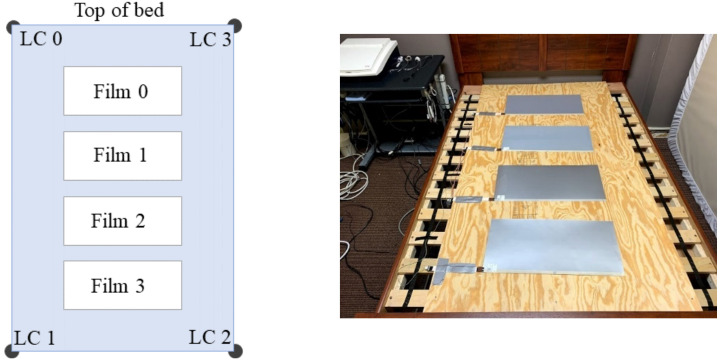

In [7]:
#Don't run this cell or you'll lose the photo
#Image of bed sensor system
#disp_img.Image("/home/imelna/data_files/BCG_Research/CinC2022_BCG_PTT_PAPER_NOTEBOOKS/bed_sensor_system.jpg")

### TASK 1 Import The Data and Down Sample all signals from 1000 Hz to 200 Hz.:

* Import all the data that came with this exercise and keep the following columns for analysis, all other columns of data can be ignored and discarded:


my_columns=["ECG",'Film0', 'Film1', 'Film2', 'Film3','LC_BCG0','LC_BCG1','LC_BCG2','LC_BCG3']

* For each column you need to downsample the data from the original 1000 Hz sampling frequency to 200 Hz.
* To do this you need to apply a 100 Hz lowpass filter to each signal before downsampling to 200 hz. This is also known as  an anti-aliasing filter. 


* <b> So to summarize <b> :
    1. Import Data
    2. Keep only the listed column names
    3. Filter each signal with a 100 Hz low pass filter
    4. Downsample each signal from 1000 Hz to 200 Hz.

##### HINT: One easy way to do this is to use dictionaries where the key is the subject ID and the value is a dataframe, as showcased in the below cell. The helper code in the later tasks below also assume that you've imported the data using a dictionary format 

In [7]:
# don't run this cell
# example of a dictionary with the key being sub1 and the value being a dataframe with the columns we wanted to keep after downsampling to 200 hz
display (data_dict["sub1"])

,ECG,Film0,Film1,Film2,Film3,LC_BCG0,LC_BCG1,LC_BCG2,LC_BCG3
0,-0.155581,1.361716,1.456826,0.850984,1.699046,0.299792,-0.471540,-0.186368,0.749975
1,-0.197400,2.165784,1.297433,0.233342,0.815010,0.299295,0.068727,0.027791,0.636647
2,-0.188681,0.724704,0.740686,-1.389769,-1.046557,0.301692,0.246596,0.247410,0.748925
3,-0.188145,1.465041,1.146419,-0.473800,0.586544,0.381479,0.528997,0.445333,0.774234
4,-0.188602,2.285431,1.766004,1.030310,1.628976,0.570517,0.694827,0.587884,0.863358
...,...,...,...,...,...,...,...,...,...
59795,-0.094830,-1.566327,0.427230,-1.376465,-1.337994,-0.242601,-1.438427,-0.716076,0.796371
59796,-0.101302,-0.354894,1.198113,0.438273,1.159481,-0.048031,-1.236653,-0.568303,1.001253
59797,-0.088656,-0.079142,1.487548,1.116990,1.127357,0.110005,-1.506717,-0.561466,1.044480
59798,-0.099160,-1.211433,0.770492,-0.784857,-1.183004,0.168084,-1.317654,-0.534788,1.074596


In [12]:
# The columns we want to use for our example
# These represent the ECG signal captures from each signal
# as well as the BCG signal captured from each sensor under the mattress
my_columns=["ECG",'Film0', 'Film1', 'Film2', 'Film3','LC_BCG0','LC_BCG1','LC_BCG2','LC_BCG3']

#LOAD PATHS
################ CHANGE PATH TO WHERE YOUR BCG DATA FOLDER IS LOCATED ################
path="*.csv"

#PARSE TO DICT
orig_Fs=1000 #original sampling frequency
new_Fs=200 # new sampling frequency 

# ADD CODE HERE # 

files = glob(path)
decimation_factor = int(orig_Fs / new_Fs)

# Defining a lowpass filter
def lowpass_filter(signal_in, cutoff=100, fs=orig_Fs, order=4):
    """
    Parameters:
        signal_in (array): Input signal to be filtered.
        cutoff (float): Cutoff frequency for the lowpass filter in Hz.
        fs (int): Sampling frequency of the input signal.
        order (int): Order of the Butterworth filter.

    Returns:
        filtered (array): The filtered signal.
    """
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    # Apply filter with zero-phase distortion
    filtered = signal.filtfilt(b, a, signal_in)
    return filtered



data_dict = {}

for file in files:
    # Extracting a subject ID from the filename.
    subject_id = file.split("/")[-1].split(".")[0]
    df = pd.read_csv(file)
    
    # Keeping only the desired columns
    df = df[my_columns]

    downsampled_data = {}  # dictionary to store downsampled columns
    
    # Processing each column: filter then downsample
    for col in my_columns:
        signal_orig = df[col].values
        
        # Applying a 100 Hz lowpass filter
        signal_filtered = lowpass_filter(signal_orig, cutoff=100, fs=orig_Fs, order=4)
        
        # Downsampling by taking every 5th sample
        signal_downsampled = signal_filtered[::decimation_factor]
        downsampled_data[col] = signal_downsampled

    # Creating a new DataFrame from the downsampled data
    df_downsampled = pd.DataFrame(downsampled_data)
    # Storing the processed downsampled DataFrame in the dictionary using subject_id as the key
    data_dict[subject_id] = df_downsampled

print("Subjects processed:", list(data_dict.keys()))
subject_sample = list(data_dict.keys())[0]
print(f"\nFirst few rows of subject {subject_sample}:")
print(data_dict[subject_sample].head())

Subjects processed: ['sub1', 'sub14', 'sub19', 'sub23', 'sub26', 'sub3', 'sub33']

First few rows of subject sub1:
        ECG     Film0     Film1     Film2     Film3   LC_BCG0   LC_BCG1  \
0 -0.033897  2.961197  3.347389  2.597625  2.916317  1.028931  1.110527   
1 -0.032480  3.022389  3.368613  2.615281  2.855555  1.028097  1.110796   
2 -0.032736  2.760340  3.257599  2.484185  2.604773  1.028353  1.112219   
3 -0.031891  2.892830  3.336345  2.558506  2.819265  1.028612  1.113122   
4 -0.032344  3.065195  3.436879  2.655598  2.941828  1.029711  1.114128   

    LC_BCG2   LC_BCG3  
0  1.029635  1.022978  
1  1.030943  1.023449  
2  1.032517  1.023591  
3  1.033802  1.023806  
4  1.034834  1.023962  


# TASK #2

## *Using the signals coming from sub14 and sub26 do the following:*

### PART A

* Plot the ECG signal, and the signal from the sensor called Film 1 (Film1) and Load Cell 0 (LC_BCG0)
* Plot only a 4 second segment of each signal and the output should look like the below example.
* <b>Make sure you bandpass filter the BCG signals between 5 and 35 Hz</b>
### PART B

* Calculate the average heart rate of the ECG signal for the given 4 second segment.
* You just need to return one value which is the average HR for the entire 4 second segment.
 
### PART C

* Give some comments about how the BCG signals from the two subject differ.
* For example talk about, why might the signal from different subjects appear to differ visually? How can this possibly make heart rate detection challenging when using BCG signals?
* Only a few (3-5) sentences are required.

 
#### Example plots of the ECG signal, and one signal from each type of BCG sensor under the mattress

Running for sub14
Mean ECG HR for this 4 second segment: 71.57057654075547 BPM


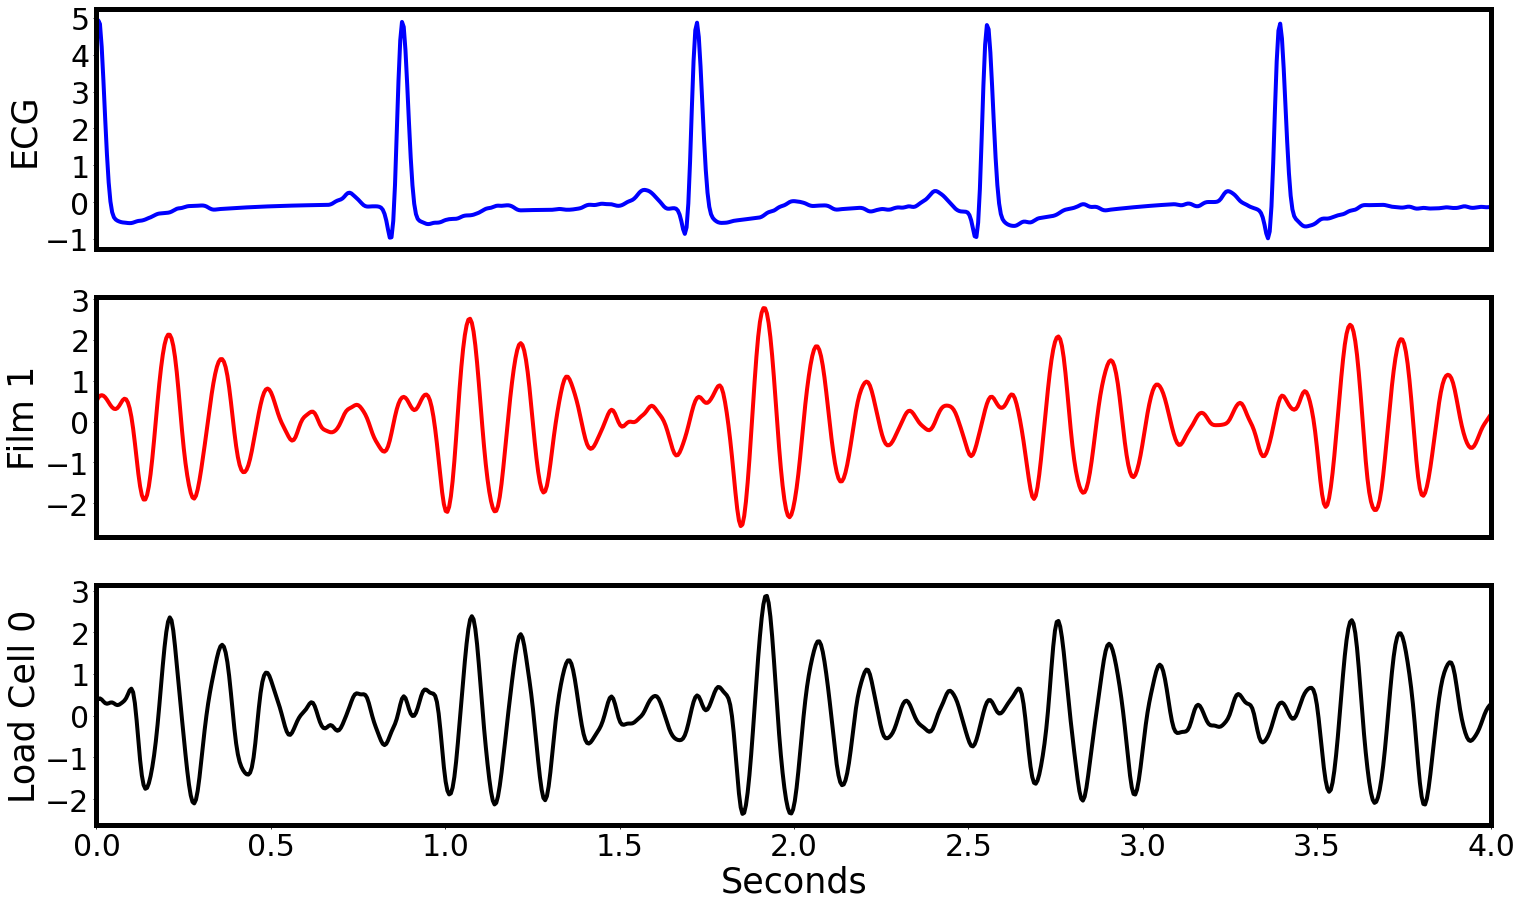

In [10]:
### DONT RUN THIS CELL ###
### YOUR CODE SHOULD OUTPUT SOMETHING LIKE THIS FOR PART A AND B ###

### Student Code for Task1 PART A AND B using Sub14 and sub26

sub14 - Average HR over 4 seconds: 71.5725673860544 BPM


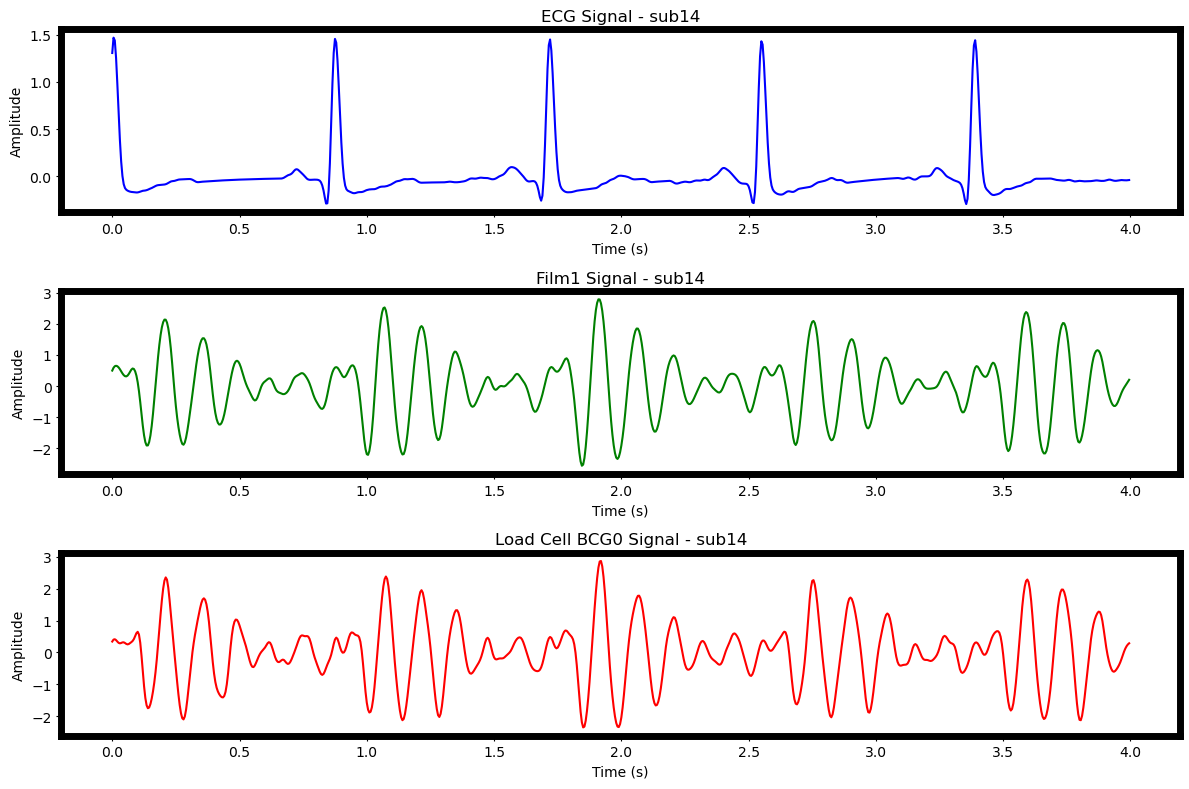

sub26 - Average HR over 4 seconds: 65.2503494505077 BPM


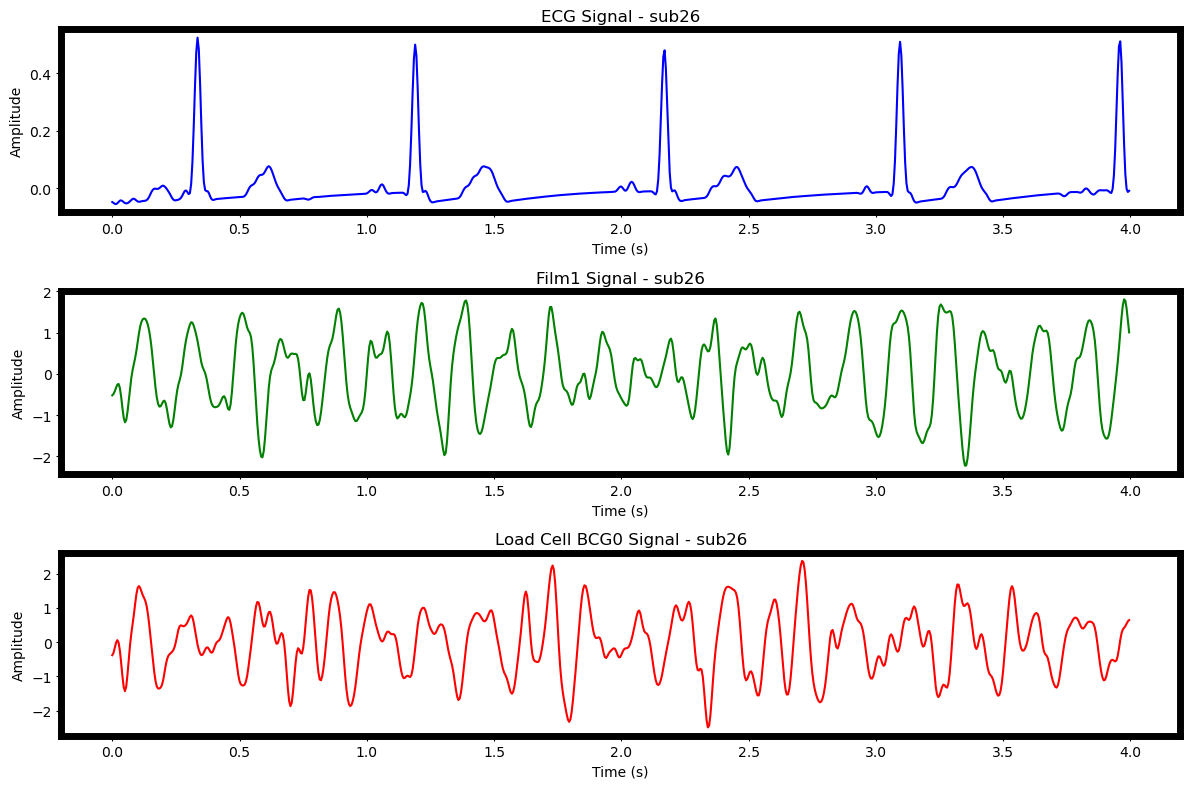

In [17]:
#### DO NOT CHANGE THESE VALUES IN THIS BOX OF COMMENTS ####
############################################################
#SAMPLING FREQUENCY
Fs=200

#time window to use, 4 seconds of signal
t1=Fs*36
t2=Fs*40
# so we are using the 4 second window from the 36th to the 40th second of signal
############################################################


# Make sure you clean the ECG signal using the neurokit function nk.ecg_clean
# provide the code below these comments to complete PART A AND PART B FOR TASK 1 for sub14 and sub26
# The output should look like the example output above in the previous cell for both subjects.

subjects = ['sub14', 'sub26']

# Processing and plotting 
for subject in subjects:
    # Getting the processed downsampled DataFrame for the subject from data_dic
    df = data_dict[subject]
    
    raw_ecg = df['ECG'].values
    # Cleaning the ECG using NeuroKit 
    cleaned_ecg = nk.ecg_clean(raw_ecg, sampling_rate=Fs)
    
    # Filtering BCG signal with bandbass filter
    
    # Film1 Signal
    raw_Film1 = df['Film1'].values
    filtered_Film1 = bp_filter(raw_Film1, hp=5, lp=35, fs=Fs, order=4)
    
    # LC_BCG0 Signal
    raw_LC_BCG0 = df['LC_BCG0'].values
    filtered_LC_BCG0 = bp_filter(raw_LC_BCG0, hp=5, lp=35, fs=Fs, order=4)
    
    # extracting the segments
    ECG_segment       = cleaned_ecg[t1:t2]
    Film1_segment     = filtered_Film1[t1:t2]
    LC_BCG0_segment   = filtered_LC_BCG0[t1:t2]

    # R-peaks detection in the ECG segment and computing the instantaneous heart rate
    rpeaks, info = nk.ecg_peaks(ECG_segment, sampling_rate=Fs)
    hr_series = nk.ecg_rate(rpeaks, sampling_rate=Fs, desired_length=len(ECG_segment))
    # function returns a heart rate time series with the same length as ECG_segment.
    
    average_hr = np.mean(hr_series)
    
    print(f"{subject} - Average HR over 4 seconds: {average_hr} BPM")
    
    # Creating a time vector for the 4-second window
    t = np.arange(len(ECG_segment)) / Fs
    
    plt.figure(figsize=(12, 8))
    

    plt.subplot(3, 1, 1)
    plt.plot(t, ECG_segment, color='blue')
    plt.title(f"ECG Signal - {subject}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    

    plt.subplot(3, 1, 2)
    plt.plot(t, Film1_segment, color='green')
    plt.title(f"Film1 Signal - {subject}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    

    plt.subplot(3, 1, 3)
    plt.plot(t, LC_BCG0_segment, color='red')
    plt.title(f"Load Cell BCG0 Signal - {subject}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    
    plt.tight_layout()
    plt.show()


#### PART C COMMENTS: 

* WRITE COMMENTS IN THIS CELL

The first one (sub 14) has more accurate signal, on the other (sub 26) there is much more noise, which why the signal isn't as sharp and notable as the other. Sub14 BCG signal is much clearer, with clear peaks that closely align with the heartbeats seen in the ECG. In contrast, sub26 BCG signal is noisier, making it harder to distinguish individual beats. This increased noise could result from factors like body movement, sensor placement, or physiological differences such as body mass or muscle tension. The additional noise in sub26 signal makes peak detection more difficult, increasing the likelihood of missed or incorrect heart rate estimations when relying only on BCG.

# TASK #3



## PART A

* Find the average heart rate per 4 second window for the ECG signal from each subject in the dataset. The result for each subject should be a heart rate array, where each element in the array is the average heart rate value for each 4 second window of time.

* NOTES:

* For peak detection we will use the kalidas2017 method from neurokit2
* ecg_signal=nk.ecg_clean(raw_ecg_signal,sampling_rate=200,method="kalidas2017")
* r_peaks=nk.ecg_findpeaks(ecg_signal, sampling_rate=200, method="kalidas2017")


## PART B

* Find the average heart rate per 4 second window for the all 8 BCG signal channels from each subject in the dataset. The result for each subject should be a heart rate array, where each element in the array is the average heart rate value for each subseqent 4 second window of time. This means that you would produce 8 heart rate arrays, 1 for each BCG signal channel.  


 
## PART C

* For each subject, find the minimum Median Absolute Error (MAE) when comparing the heart rate array from each of the eight BCG channels VS the ECG heart rate array. Report the name of the channel which produces the minimum MAE.


* For each subject, plot the ECG heart rate array and the heart rate array of the BCG channel that produced the lowest MAE.

## Part D

* Answer the given questions lists at the end of this notebook. Answers do not need to be long, 3-5 sentences each.

#### PART A CODE 
* complete the code inside the section marked "######## FILL IN MISSING CODE ########"

In [19]:
#################### Part A Code: #################### 

#################### fix/fill in missing parts to get the below code working ####################

Fs=200 #sampling frequency
epochlen=Fs*4 #epoch length 

#initiate a dictionary to hold the results
ecg_hr_array_dict=dict()

for p in data_dict.keys():

    print("Running for {0}".format(p))
    
    #initiate empty list for the nested dictionary 
    ecg_hr_array_dict[p] = {"ECG_HR": []}
    
    #nk clean ecg
    ecg_cleaned=nk.ecg_clean(data_dict[p]["ECG"],sampling_rate=Fs,method="kalidas2017")

    #detect r_peaks in the entire signals
    r_peaks=nk.ecg_findpeaks(ecg_cleaned, sampling_rate=Fs, method="kalidas2017")
    r_peaks=r_peaks["ECG_R_Peaks"]
    
    #compute heart rate in 4 second windows from our r-peak array
    #we want to ignore the 1st second and the last 4 seconds of ECG/BCG signals
    #This is because the CWT method requires it and we want to extract the HR
    #from the exact same 4 second windows as the CWT method does
    time_stamps = np.arange(Fs,len(ecg_cleaned)-epochlen,epochlen)
    
    #we step through a time_stamps range
    for start_time in time_stamps:
        #we set the end time for each window which is the start time plus the epochlen which is a 4 second window
        end_time = start_time + epochlen
        
        # noow we have a start_time and an end_time
        # we want to now find the r-peaks in between this start_time and end_time
        # and calculate the average hr for each time wnidow
        
        ######## FILL IN MISSING CODE ########
        #selecting R-peaks that fall within the current time window
        r_peaks_window = r_peaks[(r_peaks >= start_time) & (r_peaks < end_time)]
        
        #calculating RR intervals to then calculate the average heart rate
        
        rr_intervals = np.diff(r_peaks_window) / Fs
        avg_hr = 60.0 / np.mean(rr_intervals)
        
        ecg_hr_array_dict[p]["ECG_HR"].append(avg_hr)
    
        ######## FILL IN MISSING CODE ########
    
    print("Mean HR for subject {0} = {1}".format(p, np.nanmean(ecg_hr_array_dict[p]["ECG_HR"])))
    
    
    
    

Running for sub1
Mean HR for subject sub1 = 42.02113827565506
Running for sub14
Mean HR for subject sub14 = 72.54272842778202
Running for sub19
Mean HR for subject sub19 = 54.1950009666672
Running for sub23
Mean HR for subject sub23 = 55.494066419134946
Running for sub26
Mean HR for subject sub26 = 70.1058883095959
Running for sub3
Mean HR for subject sub3 = 58.119880831561446
Running for sub33
Mean HR for subject sub33 = 87.07144846319983


#### PART B CODE 
##### The following functions from the helper functions section are used to extract HR using autocorrelation from BCG signals in the following order!:

1. <b>*my_cwt=cwt_waveform_maker(windowed_bcg_signal,my_scales,wavelet_name="morl",fs=200,abs_val=True)*</b>
This function actually outputs the CWT that is produced from the windowed_bcg_signal




2. After this you need to apply <b>*cwt_stat_waveform(my_cwt,smoothwindow=)*</b>, make the smoothwindow equal to 50 milliseconds, this value has to be in samples and not ms. This function takes your my_cwt input, which is 2 dimensional, and returns a single array back. Lets call it my_stat_wav.




3. After creating my_stat_wav, we need to discard the first and last second from the signal. So <b>*my_stat_wav = my_stat_wav[Fs:-Fs]*</b>. This is because we are only interested in the middle 4 seconds and what heart rate is produced in that time window. The first and last second were only selected so that the cwt_stat_waveform function can handle the edges of the signal correctly.




4. Now that we have a my_stat_wav function that represents the original 4 second window, we need to process it with a few more functions to smooth the signal further.

    * A) Here first call the <b>*normalizesig()*</b> function on the my_stat_wav function, this will normalize it between 1-0
    * B) Next use the numpy function <b>*np.gradient()*</b> on the output of step A)
    * C) After this use the function <b>*rollingmedian(,window=)*</b> on the output of step B). Make sure the window parameter is equal to 100 milliseconds, this value must be in samples
    * D) Finally after step C), we apply the <b>*normalizesig()*</b> function again one more time.


5. Finally we have a processed signal that is ready to have the autocorrelation measured from itself. We can do this by using the  scipy function <b>*signal.correlate()*</b>. We are only concerned with the positive portion of the lag returned by signal.correlated. So you can do something like this  xc = signal.correlate(my_signal,my_signal)[len(my_signal):], where xc is the autocorrelation curve. 




6. To create a heart rate estimate from this xc curve, call the function auto_corr_hr_detector(xc) and save the value returned by this function as your heart rate value.

* complete the code inside the section marked "######## FILL IN MISSING CODE ########"


In [21]:
#################### Part B Code: #################### 

#################### fix/fill in missing parts to get the below code working ####################
fhp=5 #highpass filter value
flp=35 #lowpass filter value
my_scales=scale_selecter(scales=(fhp,flp,1),fs=200)
Fs=200 #sampling frequency
epochlen=Fs*4 #epoch length 

#initiate a dictionary to hold the results
bcg_hr_array_dict=dict()

#for p in ["sub14"]:
for p in data_dict.keys():
    print("Running for {0}".format(p))
    
    #initiate key-value
    bcg_hr_array_dict[p]={key: 0  for key in ['Film0', 'Film1', 'Film2', 'Film3','LC_BCG0','LC_BCG1','LC_BCG2','LC_BCG3']}
    
    for axz in ['Film0', 'Film1', 'Film2', 'Film3','LC_BCG0','LC_BCG1','LC_BCG2','LC_BCG3']:
        
        print(axz)
        
        #initiate empty list for the nested dictionary 
        bcg_hr_array_dict[p][axz]={key: []  for key in ["HR_array"]}
        
        #band pass filter bcg signal between 5 and 35 hz
        bcg_cleaned=bp_filter(data_dict[p][axz],hp=5,lp=35,fs=Fs,order=4)
        
        #range for 4 second windows
        # we want to ignore the 1st second and the last 4 seconds of ECG/BCG signals
        # This is because the CWT method requires it and we want to extract the HR
        # from the exact same 4 second windows as the CWT method does
        startposvec = np.arange(Fs,len(bcg_cleaned)-epochlen,epochlen)
        
        
        for startpos in startposvec:
            
            # select 1 second plus/minus window to make sure peaks
            # This is done so that the averaging of the signal isn't affected at the edges
            windowed_bcg_signal=bcg_cleaned[startpos-Fs : startpos+epochlen+Fs]
            
            #get cwt
            my_cwt,f=cwt_waveform_maker(windowed_bcg_signal,my_scales,wavelet_name="morl",fs=200,abs_val=True)
            
            
            ######## FILL IN MISSING CODE in this loop ########
            ### Using the functions in the helper functions section
            ### add the Necessary functions to produce accurate heart rate estimates taken from the 
            ### BCG signals    

            #Computing the statistical CWT waveform using a smooth window of 50 ms.
            smoothwindow_samples = int(0.05 * Fs)  # 0.05 * 200 = 10 samples
            my_stat_wav = cwt_stat_waveform(my_cwt, smoothwindow=smoothwindow_samples)
            
            #Discarding the first and last 1 second from the statistical waveform. This leaves the central 4-second segment.
            my_stat_wav = my_stat_wav[Fs:-Fs]
            
            # Normalizing the signal between -1 and 1.
            norm_sig = normalizesig(my_stat_wav)
            #Computing the gradient of the normalized signal.
            grad_sig = np.gradient(norm_sig)
            #Smoothing the gradient using a rolling median.
            smoothed_sig = rollingmedian(grad_sig, window=int(0.1 * Fs))
            #Normalizing the smoothed signal again.
            final_sig = normalizesig(smoothed_sig)
            
            #Computing the autocorrelation of the processed signal and taking only the positive lags.
            xc = signal.correlate(final_sig, final_sig)
            xc = xc[len(final_sig):]
            
            #Estimating heart rate from the autocorrelation
            HR_ESTIMATE = auto_corr_hr_detector(xc)
            
            
            #missing codes 
            
        
            bcg_hr_array_dict[p][axz]["HR_array"].append(HR_ESTIMATE)
            ######## FILL IN MISSING CODE in this loop ########
  
    

Running for sub1
Film0
Film1
Film2
Film3
LC_BCG0
LC_BCG1
LC_BCG2
LC_BCG3
Running for sub14
Film0
Film1
Film2
Film3
LC_BCG0
LC_BCG1
LC_BCG2
LC_BCG3
Running for sub19
Film0
Film1
Film2
Film3
LC_BCG0
LC_BCG1
LC_BCG2
LC_BCG3
Running for sub23
Film0
Film1
Film2
Film3
LC_BCG0
LC_BCG1
LC_BCG2
LC_BCG3
Running for sub26
Film0
Film1
Film2
Film3
LC_BCG0
LC_BCG1
LC_BCG2
LC_BCG3
Running for sub3
Film0
Film1
Film2
Film3
LC_BCG0
LC_BCG1
LC_BCG2
LC_BCG3
Running for sub33
Film0
Film1
Film2
Film3
LC_BCG0
LC_BCG1
LC_BCG2
LC_BCG3


#### PART C Code 

For each subject, calculate the Median Absolute Error (MAE) vs the heart rate array for each of the eight BCG channels. Report the name of the channel which produces the minimum MAE.

For each subject, plot the ECG heart rate array and the heart rate array of the BCG channel that produced the lowest MAE.

sub1: Best channel is Film1 with MAE = 0.4781


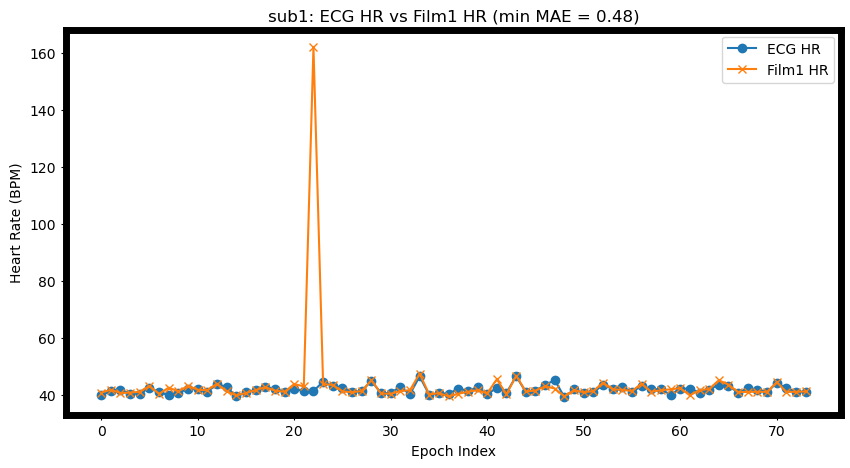

sub14: Best channel is LC_BCG0 with MAE = 0.8216


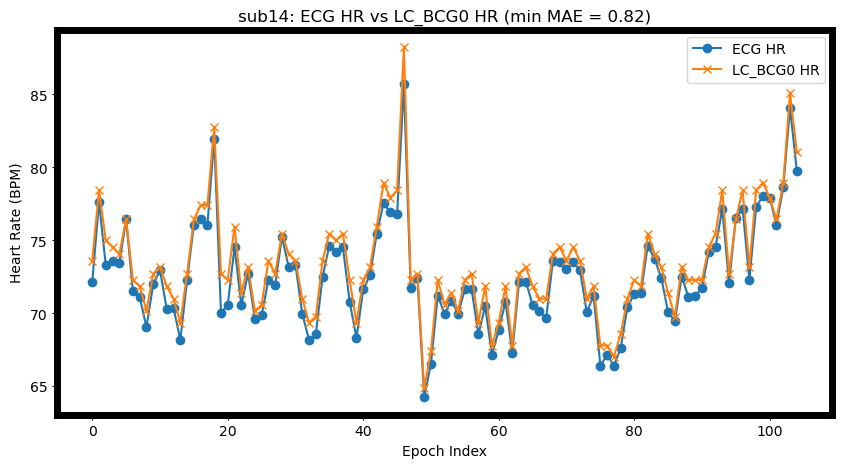

sub19: Best channel is Film3 with MAE = 0.3612


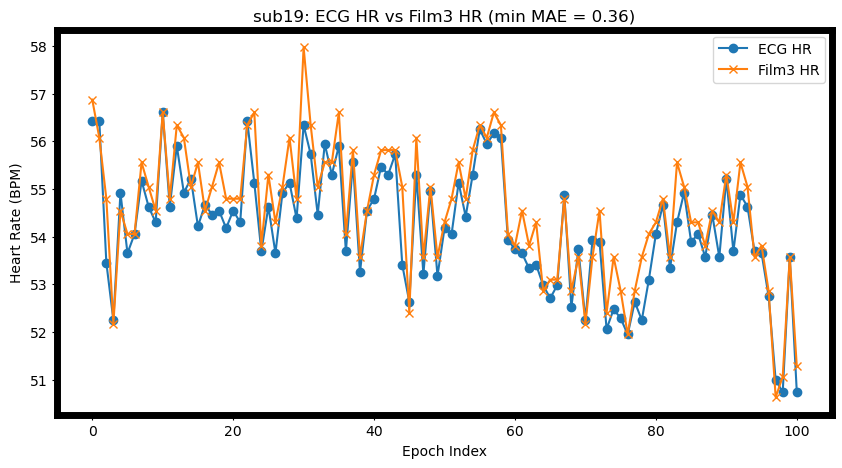

sub23: Best channel is Film1 with MAE = 0.5059


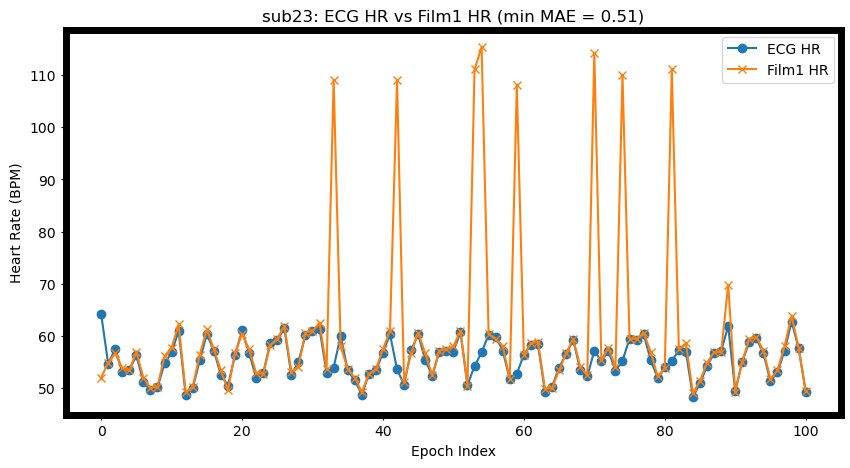

sub26: Best channel is LC_BCG1 with MAE = 1.1075


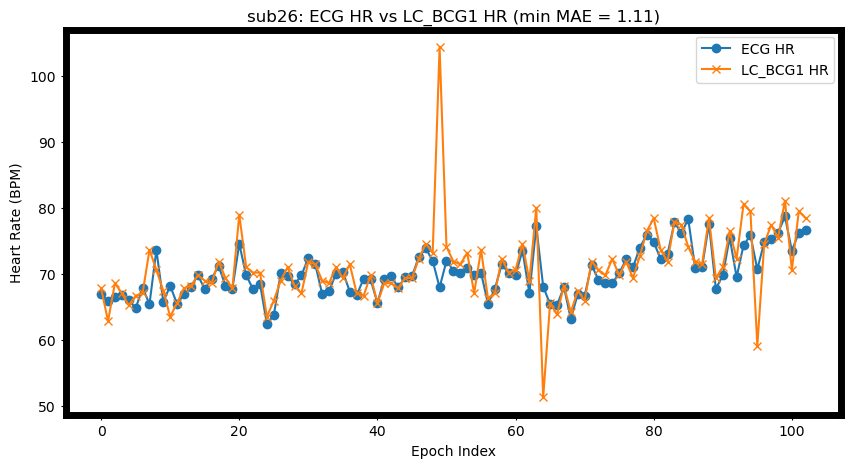

sub3: Best channel is LC_BCG2 with MAE = 0.7817


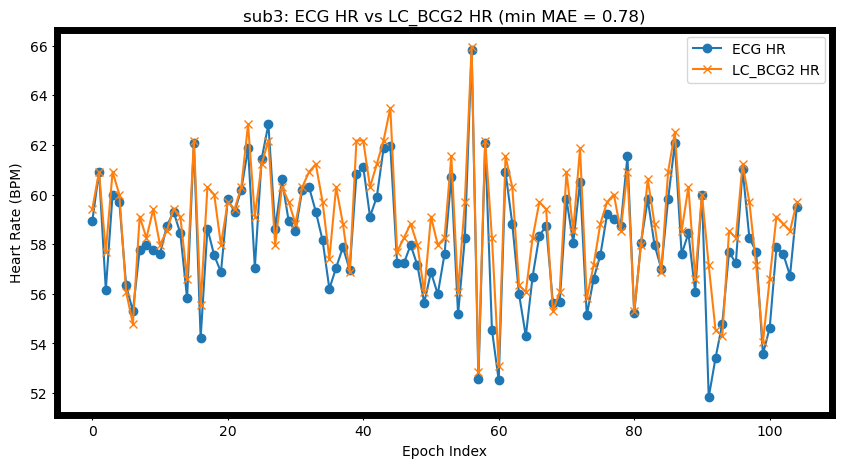

sub33: Best channel is Film0 with MAE = 0.9086


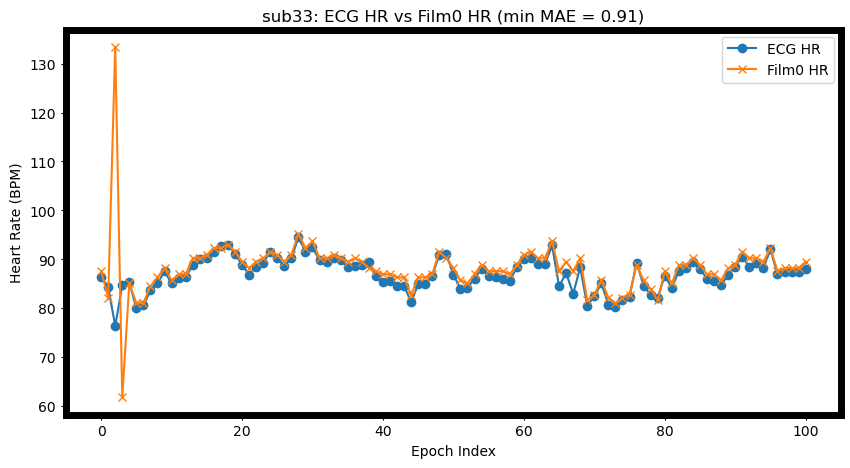

In [25]:
# plot the ECG with the BCG channel that produced the lowest MAE for each subject

#code cell

# Defining the channels.
channels = ['Film0', 'Film1', 'Film2', 'Film3', 'LC_BCG0', 'LC_BCG1', 'LC_BCG2', 'LC_BCG3']

# Looping over all subjects
for p in data_dict.keys():
    
    # Getting the ECG heart rate array for the subject.
    ecg_hr = ecg_hr_array_dict[p]["ECG_HR"]
    
    # Initialize a dictionary to store the MAE.
    mae_dict = {}
    
    # Loop over each and calculate the MAE.
    for channel in channels:
        bcg_hr = bcg_hr_array_dict[p][channel]["HR_array"]
        
        # Calculating the median absolute error
        mae = median_absolute_error(ecg_hr, bcg_hr)
        mae_dict[channel] = mae
    
    # Identifying the channel that produced the minimum MAE.
    best_channel = min(mae_dict, key=mae_dict.get)
    min_mae = mae_dict[best_channel]
    
    print(f"{p}: Best channel is {best_channel} with MAE = {min_mae:.4f}")
    
    plt.figure(figsize=(10, 5))
    plt.plot(ecg_hr, marker="o", label="ECG HR")
    plt.plot(bcg_hr_array_dict[p][best_channel]["HR_array"], marker="x", label=f"{best_channel} HR")
    plt.xlabel("Epoch Index")
    plt.ylabel("Heart Rate (BPM)")
    plt.title(f"{p}: ECG HR vs {best_channel} HR (min MAE = {min_mae:.2f})")
    plt.legend()
    plt.show()

#### Part D Questions

Question:

* Does the same channel produce the lowest MAE when compared to the HR produced by the ECG for each subject, if not why do you think it might not?
* What are some possible pros and cons of using a bed based BCG system compared to a typical 1-lead ECG for HR monitoring in patients when they are laying in a bed?
* What demographic in your opinion could benefit the most from non-invasive monitoring systems like a bed-based BCG heart monitoring system? 

1. No, the best channel for each subject varies. For example, sub1 has the lowest MAE with Film1, whereas sub14 performs best with LC_BCG0. This variation is likely result from differences in physiological factors such as body mass, movement, and how the subject interacts with the bed-based sensor. Additionally, external noise, sensor placement, and individual heart mechanics could influence the signal quality, leading to different optimal channels for each person.

2.

Pros:
Completely non-invasive method, requiring no physical electrodes on the body. More comfortable for long-term monitoring, especially for patients in bed.
Provides additional insights into ballistographic (body movement) data beyond just heart rate.

Cons:
More exposed to noise from body movements or changes in position. Can be less accurate than ECG, particularly in detecting arrhythmias or sudden changes in HR. Variability in sensor sensitivity can make it difficult to standardize across patients.

3. Elderly patients, particularly those in long-term care or ICU settings, would benefit from a bed-based BCG system. It allows continuous heart monitoring without causing discomfort or skin irritation from ECG electrodes. Additionally, patients with chronic conditions such as heart failure or sleep apnea could benefit from passive monitoring, reducing the need for frequent manual checks by medical staff. Tracking heart rate and body movements during sleep could help identify issues like restlessness or recovery quality. Since athletes rely on optimal recovery for performance, monitoring HR variability and movement patterns could provide valuable insights into their recovery process. Additionally, non-invasive monitoring ensures that their sleep isn't disturbed by wearable devices, leading to more accurate and natural sleep tracking.